In [66]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import push_notebook, output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, linear_cmap, jitter
from bokeh.models import HoverTool, Select, CustomJS, ColorBar
from bokeh.layouts import column, row
from bokeh.palettes import Plasma256
from ipywidgets import interact
from pandas_profiling import ProfileReport
import plotly
import re
import itertools
import plotly.express as px

output_notebook()
%matplotlib inline

Loading BokehJS ...

Load Iris dataset with correct names. Show a sample of 10 rows.

In [129]:
iris = load_iris(as_frame=True)['data']
iris['Species'] = load_iris(as_frame=True)['target']
iris['Species'] = iris['Species'].map(pd.Series(load_iris().target_names))
iris.columns = iris.columns.str.replace("\ \(cm\)", "")
iris.columns = iris.columns.str.replace("\s", "_")
iris_scaled = iris.copy()
for col in iris.columns[:-1]:
    iris_scaled[col+"_scaled"] = ((iris[col] - iris[col].min())/(iris[col].max()-iris[col].min())+1) * 10
iris_scaled.sample(10)

<ipython-input-129-7bfcd347eccc>:4: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-129-7bfcd347eccc>:5: FutureWarning:

The default value of regex will change from True to False in a future version.



,sepal_length,sepal_width,petal_length,petal_width,Species,sepal_length_scaled,sepal_width_scaled,petal_length_scaled,petal_width_scaled
117,7.7,3.8,6.7,2.2,virginica,19.444444,17.500000,19.661017,18.750000
81,5.5,2.4,3.7,1.0,versicolor,13.333333,11.666667,14.576271,13.750000
80,5.5,2.4,3.8,1.1,versicolor,13.333333,11.666667,14.745763,14.166667
39,5.1,3.4,1.5,0.2,setosa,12.222222,15.833333,10.847458,10.416667
1,4.9,3.0,1.4,0.2,setosa,11.666667,14.166667,10.677966,10.416667
6,4.6,3.4,1.4,0.3,setosa,10.833333,15.833333,10.677966,10.833333
30,4.8,3.1,1.6,0.2,setosa,11.388889,14.583333,11.016949,10.416667
16,5.4,3.9,1.3,0.4,setosa,13.055556,17.916667,10.508475,11.250000
91,6.1,3.0,4.6,1.4,versicolor,15.000000,14.166667,16.101695,15.416667
136,6.3,3.4,5.6,2.4,virginica,15.555556,15.833333,17.796610,19.583333


Use The Pandas Profiling package to view key statistics about our data.

## Exploring the Data

In [68]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [69]:
iris.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
Species          object
dtype: object

We have four feature variables that are continuous values. "Species" the target variable is categorical.

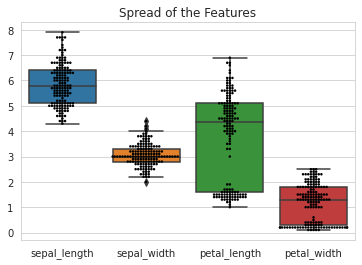

In [70]:
sns.boxplot(data=iris)
sns.swarmplot(data=iris, size=2.5, color='black')
plt.title('Spread of the Features')
plt.show()

In "Petal Length" and "Petal Width" there is a noticable gap between high and low values. "Petal Length" also has a hint of skewness.

In [71]:
for  col in iris.columns[:-1]:
    IQR = iris[col].quantile(0.75) - iris[col].quantile(0.25)
    out = sum(iris[col] >  iris[col].quantile(0.75) + 1.5 * IQR) + sum(iris[col] <  iris[col].quantile(0.25) - 1.5 * IQR)
    print("There are ", out, "outliers in the ", col, "feature")

There are  0 outliers in the  sepal_length feature
There are  4 outliers in the  sepal_width feature
There are  0 outliers in the  petal_length feature
There are  0 outliers in the  petal_width feature


While there are a few outliers in "Sepal Width" they are close enough that we intend to keep them for our analysis

In [72]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


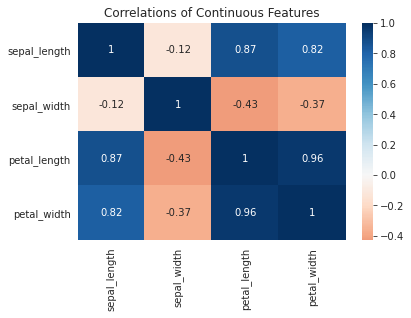

In [73]:
sns.heatmap(iris.corr(),center=0, annot=True, cmap='RdBu')
plt.title('Correlations of Continuous Features')
plt.xticks(rotation=90)
plt.show()

There are features that are highly correlated with each other. For example, "Petal Width" is highly correlated with both "Sepal Length" and "Petal Length". Also, "Sepal Length" is highly correlated with "Petal Length". "Sepal Width" is interestingly negatively correlated with all other features.

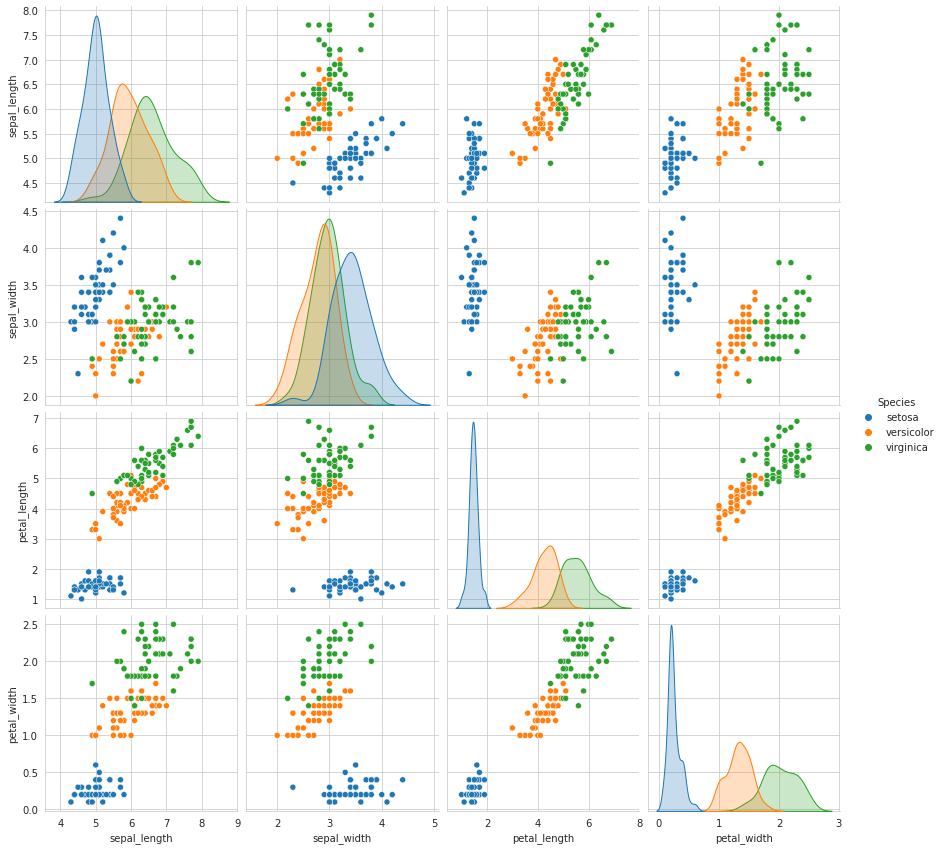

In [74]:
sns.set_style("whitegrid")
sns.pairplot(iris, hue="Species",  height=3)
plt.show()

In all of the above 2-D scatter plots shows a clear seperation of setosa from versicolor and virginica. "Petal Length" has a good potential of being the best indicator to distinguish versicolor and verginica. 

In [75]:
for comb in itertools.combinations(iris.columns[:4], 2):
    dot = np.dot(iris[comb[0]],iris[comb[1]])
    print('The dot product between {0} and {1} = {2:.2f}'.format(comb[0], comb[1], dot))

The dot product between sepal_length and sepal_width = 2673.43
The dot product between sepal_length and petal_length = 3483.76
The dot product between sepal_length and petal_width = 1128.14
The dot product between sepal_width and petal_length = 1674.30
The dot product between sepal_width and petal_width = 531.89
The dot product between petal_length and petal_width = 869.11


In [76]:
iris.iloc[:,:4].apply(np.linalg.norm)

sepal_length    72.276206
sepal_width     37.820629
petal_length    50.820370
petal_width     17.387639
dtype: float64

In [77]:
for comb in itertools.combinations(iris.columns[:4], 2):
    dist = np.linalg.norm(iris[comb[0]] - iris[comb[1]])
    print('Distance between {0} and {1} = {2:.2f}'.format(comb[0], comb[1], dist))

Distance between sepal_length and sepal_width = 36.16
Distance between sepal_length and petal_length = 28.97
Distance between sepal_length and petal_width = 57.18
Distance between sepal_width and petal_length = 25.78
Distance between sepal_width and petal_width = 25.86
Distance between petal_length and petal_width = 33.86


In [78]:
ProfileReport(iris).to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


Pandas Profiling provides many EDA measurments that allow for quick exploration of these statistics. It is really easy to visualize the distribution for each feature, quickly find significant statistical measures, and gain an overall understanding of your data.

## Bokeh Visualizations

Please select desired x and y plot variables from the dropdown menues on the right of the plots. To investigate a particular point hover your mouse over it. You may also pan, scroll zoom, and box zoom from selecting the tool in the plot tools menu to the right of the plot.

In [92]:
#Create Default 2D plot
p1 = figure(title='2D Exploratory Plot of Iris Data')
r1 = p1.circle('sepal_length','sepal_width', source=iris_scaled, 
    color = factor_cmap('Species', 'Category10_3', ['versicolor','virginia','setosa']), 
    legend_field='Species', 
    size =10, 
    alpha =0.5)
p1.add_tools(HoverTool(
    tooltips=[('index', '@index'),
    ('Species', '@Species'), 
    ('Sepal Length (cm)', '@sepal_length{2.2f}'), 
    ('Sepal Width (cm)', '@sepal_width{2.2f}'), 
    ('Petal Length (cm)', '@petal_length{2.2f}'), 
    ('Petal Width (cm)', '@petal_width{2.2f}')]))
p1.legend.location = "top_left"
p1.xaxis.axis_label='Sepal Length'
p1.yaxis.axis_label='Sepal Width'

#Create functionalty to change x axis
handx = CustomJS(args=dict(r = r1, ax = p1.xaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.x = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.x = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.x = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.x = {field: 'petal_width'};
    }
    ax.axis_label = cb_obj.value;
    """)  
selx = Select(title="x", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Length') 
selx.js_on_change('value', handx)

#Create functionality to change y axis
handy = CustomJS(args=dict(r = r1, ay=p1.yaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.y = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.y = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.y = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.y =  {field: 'petal_width'};
    }
    ay.axis_label = cb_obj.value;
    """)
sely = Select(title="y", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Width') 
sely.js_on_change('value', handy)

show(row(p1,column(selx,sely)), notebook_handle=True)

By setting an alpha value less then one we can clearly see overlapping data points.

In [130]:
p2 = figure(title='Exploratory Plot of Iris Data')
r2 = p2.scatter('sepal_length','sepal_width', source=iris_scaled, 
    color = factor_cmap('Species', 'Category10_3', ['versicolor','virginia','setosa']), 
    legend_field='Species', 
    size = 'petal_length_scaled', 
    alpha =0.5)
p2.add_tools(HoverTool(
    tooltips=[('index', '@index'),
    ('Species', '@Species'), 
    ('Sepal Length (cm)', '@sepal_length{2.2f}'), 
    ('Sepal Width (cm)', '@sepal_width{2.2f}'), 
    ('Petal Length (cm)', '@petal_length{2.2f}'), 
    ('Petal Width (cm)', '@petal_width{2.2f}')]))
p2.legend.location = "top_left"
p2.xaxis.axis_label='Sepal Length'
p2.yaxis.axis_label='Sepal Width'

handx = CustomJS(args=dict(r = r2, ax = p2.xaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.x = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.x = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.x = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.x = {field: 'petal_width'};
    }
    ax.axis_label = cb_obj.value;
    """)  
selx = Select(title="x", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Length') 
selx.js_on_change('value', handx)

handy = CustomJS(args=dict(r = r2, ay = p2.yaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.y = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.y = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.y = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.y = {field: 'petal_width'};
    }
    ay.axis_label = cb_obj.value;
    """)   
sely = Select(title="y", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Width') 
sely.js_on_change('value', handy)

handz = CustomJS(args=dict(r = r2), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.size = {field: 'sepal_length_scaled'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.size = {field: 'sepal_width_scaled'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.size = {field: 'petal_length_scaled'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.size = {field: 'petal_width_scaled'};
    }
    """)   
selz = Select(title="size", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Petal Length') 
selz.js_on_change('value', handz)

show(row(p2,column(selx,sely,selz)), notebook_handle=True)

In [127]:
cmap = linear_cmap('petal_length', Plasma256, high=7, low=1)
p3 = figure(title='Exploratory Plot of Iris Data')
r3 = p3.circle(jitter('sepal_length', 0.4),'sepal_width', source=iris, 
    color = cmap,  
    size=10)
p3.add_tools(HoverTool(
    tooltips=[('index', '@index'),
    ('Species', '@Species'), 
    ('Sepal Length (cm)', '@sepal_length{2.2f}'), 
    ('Sepal Width (cm)', '@sepal_width{2.2f}'), 
    ('Petal Length (cm)', '@petal_length{2.2f}'), 
    ('Petal Width (cm)', '@petal_width{2.2f}')]))
p3.xaxis.axis_label='Sepal Length'
p3.yaxis.axis_label='Sepal Width'
color_bar = ColorBar(color_mapper=cmap['transform'])
p3.add_layout(color_bar, 'right')

handx = CustomJS(args=dict(r = r3, ax = p3.xaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.x = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.x = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.x = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.x = {field: 'petal_width'};
    }
    ax.axis_label = cb_obj.value;
    """)  
selx = Select(title="x", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Length') 
selx.js_on_change('value', handx)

handy = CustomJS(args=dict(r = r3, ay = p3.yaxis[0]), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        r.glyph.y = {field: 'sepal_length'};
    } else if (cb_obj.value == 'Sepal Width'){
        r.glyph.y = {field: 'sepal_width'};
    } else if (cb_obj.value == 'Petal Length'){
        r.glyph.y = {field: 'petal_length'};
    } else if (cb_obj.value == 'Petal Width'){
        r.glyph.y = {field: 'petal_width'};
    }
    ay.axis_label = cb_obj.value;
    """)   
sely = Select(title="y", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Sepal Width') 
sely.js_on_change('value', handy)

handz = CustomJS(args=dict(r = r3, map=cmap['transform']), 
    code="""
    if (cb_obj.value == 'Sepal Length'){
        map.low=4.3
        map.high=7.9
        r.glyph.fill_color = {field: 'sepal_length', transform : map};
        r.glyph.line_color = {field: 'sepal_length', transform : map};
    } else if (cb_obj.value == 'Sepal Width'){
        map.low=2
        map.high=4.4
        r.glyph.fill_color = {field: 'sepal_width', transform : map};
        r.glyph.line_color = {field: 'sepal_width', transform : map};
    } else if (cb_obj.value == 'Petal Length'){
        map.low=1
        map.high=6.9
        r.glyph.fill_color = {field: 'petal_length', transform : map};
        r.glyph.line_color = {field: 'petal_length', transform : map};
    } else if (cb_obj.value == 'Petal Width'){
        map.low=0.1
        map.high=2.5
        r.glyph.fill_color = {field: 'petal_width', transform : map};
        r.glyph.line_color = {field: 'petal_width', transform : map};
    }
    """)   
selz = Select(title="color", options=['Sepal Length','Sepal Width', 'Petal Length', 'Petal Width'], value='Petal Length') 
selz.js_on_change('value', handz)

show(row(p3, column(selx,sely,selz)), notebook_handle=True)

For this particular plot instead of setting a alpha value jitter is enabled on the x-axis. Alpha value color variation makes it hard to fully understand "color" coordinate.

Bokeh is a very good package to create interactive visualizations. We feel like Bokeh allows for quicker plot analysis then traditional plotting libraries. For example, it is easy to zoom in on a particular section of your plot without having to change range values and regenerate the plot.

## 3-D Plot with Plotly

Hold left click to rotate, hold right click to pan, scroll to zoom, and hover over data points to get data specific information. 



In [84]:
multi_plot2 = px.scatter_3d(iris , x='sepal_length', y='sepal_width', z='petal_width', color='petal_length', size='petal_length', size_max=18, symbol='Species', opacity=0.7)
multi_plot2.update_layout(margin=dict(l=0, r=0, b=0, t=0),width=800, height=700,legend=dict( yanchor="top", y=0.99, xanchor="left", x=0.01 ) ) 

multi_plot2.show() 

It is easy to see that "Setosa" is clearly seperated from the other two species when visualized in the three spacial dimensions. The size and color of the data points depict the "Petal Length" variable. This continues to point out the seperation of "Setosa" when adding a fourth dimension. The gradient of the color shows the high correlation between "Petal Length" to "Sepal Width" and "Petal Width"